In [1]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import string
import matplotlib.pyplot as plt
import pymongo
from langmodels.corpora.moviedialog import MovieDialogCollection
import spacy
import os
import json
from statistics import mean
import seaborn as sns

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding
from tensorflow.keras.callbacks import EarlyStopping
from keras import backend as K
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors
from sklearn.model_selection import ShuffleSplit
import keras_tuner

In [3]:
from abc import ABC, abstractmethod
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import contractions

# Importing the training set

In [7]:
db_name = 'Emobank'
collection = 'text'
m = {'$match': {'split': 'train'}}
p = {'$project': {'_id': 0, 'id': 1, 'text': 1, 'V':1, 'A':1, 'D':1}}
pipeline = [m,p]
training_set = MovieDialogCollection(db_name, collection, 
                            use_pos=False, mix_pos=False, lemma=True, pipeline=pipeline)
training_set_idTokens = training_set.get_tokens()

### Filter the token list that contains only a space

In [8]:
def filter_token_list(idToken_list:list):
    """Function that takes in input a list of tuples. Each tuple is composed of (id_text, [tokens])
    where id_text is the id of the text and [tokens] is a list with the tokens of the text. This function 
    filter the tuple that contains only one token in [tokens] equal to a space.
    
    Parameters
    ------------------------
    idToken_list:list,
        The list of lists fo .
        
    Returns
    ------------------------
    Return the ids of the tuples that are filtered and a list with the [tokens] of the texts that passed the filter.
    """
    idx_to_be_filtered = []
    TokensList_Filtered = []
    for idx, list_tokens in idToken_list:
        if list_tokens == [' ']:
            idx_to_be_filtered.append(idx)
        else:
            TokensList_Filtered.append(list_tokens)
    return idx_to_be_filtered, TokensList_Filtered

In [9]:
idx_to_be_filtered_trs, training_set_Tokens_Filtered = filter_token_list(training_set_idTokens)

In [10]:
training_set_idTokens[0]

('110CYL068_1127_1130', [' '])

In [11]:
idx_to_be_filtered_trs

['110CYL068_1127_1130',
 '114CUL057_422_423',
 'NYTnewswire2_5210_5211',
 'NYTnewswire9_7753_7754',
 'The_Black_Willow_13707_13709',
 'aspca1_4774_4778',
 'captured_moments_8952_8953']

# Create the vocabulary and the word index

In [12]:
voc_train = training_set.vocabulary
voc_train.append('<UNK>')
word_index_train = dict(zip(voc_train, range(len(voc_train))))

### Computing the mean value of the length of the texts

In [13]:
def plot_length_texts(tokens_list: list, save:bool=False):
    """Plot the histogram of the length of the tokens.
    
    Parameters
    ------------------------
    tokens_list:list,
        The list of tokens from which calculate the length and plot it.
    save:bool=False,
        Whether to save the image.
        
    Returns
    ------------------------
    Return the metrics calculated from the length of the tokens (count, mean, std, min, 25%, 50%, 75%, max) and the mean.
    """
    %matplotlib inline
    text_len = [len(x) for x in tokens_list]
    plt.figure(figsize=(20,10))
    plt.xticks(ticks=list(set(text_len)), labels=list(set(text_len)), rotation = 'vertical')
    pd.Series(text_len).hist(bins='auto')
    if save:
        plt.savefig(os.path.join('hist_lenght_test.eps'), dpi=300, format='eps', bbox_inches='tight')
    plt.show()
    metrics = pd.Series(text_len).describe()
    return metrics, int(metrics[1])

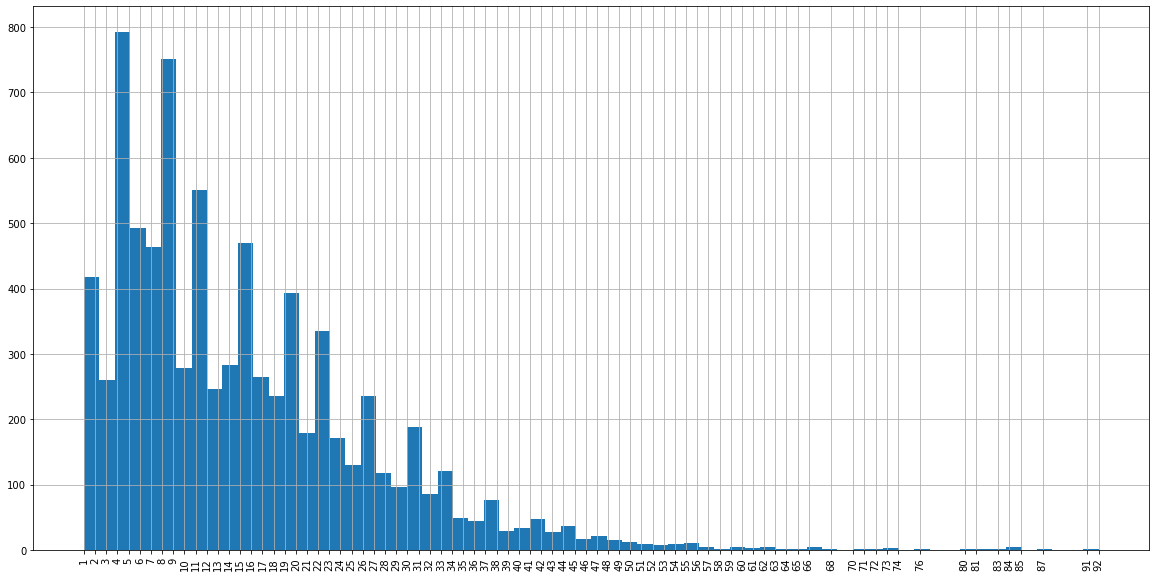

count    8054.000000
mean       15.263968
std        11.296776
min         1.000000
25%         7.000000
50%        13.000000
75%        21.000000
max        92.000000
dtype: float64


In [14]:
metrics_trs, mean_length_train = plot_length_texts(training_set_Tokens_Filtered)
print(metrics_trs)

The mean length will be used as the length for all the texts.

In [15]:
mean_length_train

15

### Function that transform a list of tokens in a list of int (based on the word_index) of given length.

In [16]:
def vectorizer(word_index:dict, list_tokens:list, max_length:int):
    """Function that takes as input a list of tokens and transforms it in a list of int (based on the word index)
    and that uniform the length of the list based on the variable max_length.
    
    Parameters
    ------------------------
    word_index:dict,
        Dictionary that contains the int value that represent each word in the vocabulary.
    list_tokens:list,
        List of tokens contained in a text.
    max_length:int,
        Length to give to the list of int.
        
    Returns
    ------------------------
    Return the list of int.
    """
    list_tokens2idx = []
    for word in list_tokens:
        try:
            list_tokens2idx.append(word_index[word])
        except KeyError:
            list_tokens2idx.append(word_index['<UNK>'])
    if len(list_tokens2idx)> max_length:
        list_tokens2idx = list_tokens2idx[:max_length]
    elif len(list_tokens2idx) < max_length:
        for i in range(max_length-len(list_tokens2idx)):
            list_tokens2idx.append(word_index['<UNK>'])
    return list_tokens2idx

# Import the test set

In [17]:
db_name = 'Emobank'
collection = 'text'
m = {'$match': { '$or' : [{'split': 'test'}, {'split': 'dev'}]
    
}}
p = {'$project': {'_id': 0, 'id': 1, 'text': 1, 'V':1, 'A':1, 'D':1}}
pipeline = [m,p]
test_set = MovieDialogCollection(db_name, collection, 
                            use_pos=False, mix_pos=False, lemma=True, pipeline=pipeline)
test_set_idTokens = test_set.get_tokens()
#test_set_Tokens = [tokens for (id, tokens) in test_set_idTokens]

### Filter the token list that contains only a space

In [18]:
idx_to_be_filtered_tes, test_set_Tokens_Filtered = filter_token_list(test_set_idTokens)

In [19]:
idx_to_be_filtered_tes

['NYTnewswire9_4647_4648', 'detroit_699_706']

## Import the labels
### Of the training set

In [20]:
training_set_idLabels = training_set.get_labels()

In [21]:
training_set_idLabels[0]

('110CYL068_1127_1130', 3.0, 3.0, 3.0)

In [22]:
len(training_set_idLabels)

8061

#### Obtain the labels of only the texts that passed the filter

In [23]:
training_set_idLabels_filtered = [x for x in training_set_idLabels if x[0] not in idx_to_be_filtered_trs]

In [24]:
len(training_set_idLabels_filtered)

8054

In [25]:
y_train = np.array([elem[1:] for elem in training_set_idLabels_filtered])
df_y_train = pd.DataFrame(y_train, columns=['Valence', 'Arousal', 'Dominance'])

### Of the test set

In [26]:
test_set_idLabels = test_set.get_labels()

In [27]:
len(test_set_idLabels)

2000

#### Obtain the labels of only the texts that passed the filter

In [28]:
test_set_idLabels_filtered = [x for x in test_set_idLabels if x[0] not in idx_to_be_filtered_tes]

In [29]:
len(test_set_idLabels_filtered)

1998

In [30]:
y_test = np.array([elem[1:] for elem in test_set_idLabels_filtered])
df_y_test = pd.DataFrame(y_test, columns=['Valence', 'Arousal', 'Dominance'])

## Plot of the dependance of the dimensions

In [31]:
df_y_all = pd.concat([df_y_train, df_y_test])

In [32]:
def scatter_plot_with_trend(x:np.array, y:np.array, x_name:str, y_name:str, save:bool=False):
    """Plot the labels in the 2 dimensions specified and draw the tren line for each dimension.
    
    Parameters
    ------------------------
    x:np.array,
        Values to plot on the x-axis.
    y:np.array,
        Values to plot on the y-axis.
    x_name:str,
        Name of the dimension on the x-axis.
    y_name:str,
        Name of the dimension on the y-axis.
    save:bool=False,
        save:bool=False
        
    Returns
    ------------------------
    
    """
    plt.scatter(x,y, alpha=0.5)
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.xlim(1,5)
    plt.ylim(1,5)
    z = np.polyfit(x, y, 2)
    p = np.poly1d(z)
    z2 = np.polyfit(y, x, 2)
    p2 = np.poly1d(z2)
    xs = np.sort(x)
    plt.plot(xs,p(xs),"r", label=x_name)
    ys = np.sort(y)
    plt.plot(p2(ys), ys,"b", label=y_name)
    plt.grid()
    plt.legend()
    if save:
        plt.savefig(os.path.join('scatter-trend_{0}{1}.eps'.format(x_name, y_name)), dpi=300, format='eps', bbox_inches='tight')
    plt.show()

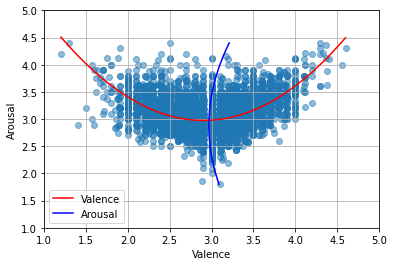

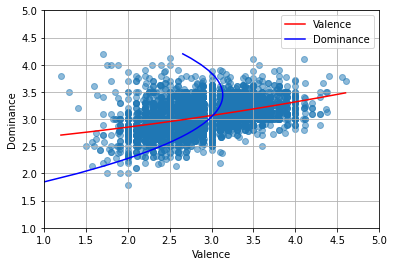

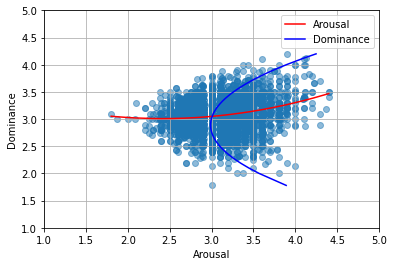

In [33]:
column_names = df_y_all.columns.values.tolist()
for i, column_name in enumerate(column_names):
    for j in range(i+1, len(column_names)):
        x = df_y_all[column_name].to_numpy()
        y = df_y_all[column_names[j]].to_numpy()
        scatter_plot_with_trend(x, y, column_name, column_names[j])

## Import the words VAD

In [35]:
BRM_emot = pd.read_csv('dati/BRM-emot-submit.csv', index_col='Number')
BRM_emot_filtered = BRM_emot[['Word', 'V.Mean.Sum', 'A.Mean.Sum', 'D.Mean.Sum']]

## Create the features vectors of the words

### Import the vectorization of the words from Google Code

In [36]:
Google_wordVector = 'dati/GoogleNews-vectors-negative300.bin'
gen = KeyedVectors.load_word2vec_format(
        Google_wordVector, binary=True)

In [37]:
def create_embedding_matrix(vocabulary: list, keyedVectors: KeyedVectors, word_index:dict,
                           BRM_emot_filtered: pd.DataFrame):
    """Create the embedding matrix to be fed to the LSTM Layer.
    
    Parameters
    ------------------------
    vocabulary: list,
        List of the words in the vocabulary.
    keyedVectors: KeyedVectors,
        KeyedVectors that contains the vectors of the words.
    word_index:dict,
        Dictionary that contains the int value that represent each word in the vocabulary.
    y_name:str,
        Name of the dimension on the y-axis.
    BRM_emot_filtered: pd.DataFrame,
        DataFrame that contains 14k words with their VAD values. 
        
    Returns
    ------------------------
    The embedding matrix
    """
    features_number = keyedVectors.vector_size+3
    embedding_matrix = np.zeros((len(vocabulary), features_number))
    for word, i in word_index.items():
        try:
            embedding_vector = keyedVectors.get_vector(word)
        except KeyError:
            embedding_vector = np.random.normal(size=(keyedVectors.vector_size, ))
            
            
        word_VAD = BRM_emot_filtered[BRM_emot_filtered['Word']==word]
        if word_VAD.empty:
            word_VAD = np.array([5,5,5])
        else:
            word_VAD = word_VAD.values[0][1:]
            
        embedding_vector = np.append(embedding_vector, word_VAD)
        embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [38]:
embedding_matrix_train = create_embedding_matrix(voc_train, gen, word_index_train, BRM_emot_filtered)

# Create the model

In [39]:
number_of_splits = 10

regression_holdouts_generator = ShuffleSplit(
    n_splits=number_of_splits,
    test_size=0.2
)

In [40]:
def pearson_r(y_true:tf.Tensor, y_pred:tf.Tensor):
    """Function that calculates the Pearson Correlation Coefficient r between the two sets of data.
    
    Parameters
    ------------------------
    y_true:tf.Tensor, 
        Tensor with the ground truth.
    y_pred:tf.Tensor,
        Tensor with the predictions.
        
    Returns
    ------------------------
    The Pearson Correlation Coefficient r.
    """
    x = y_true
    y = y_pred
    mx = K.mean(x, axis=0)
    my = K.mean(y, axis=0)
    xm, ym = x - mx, y - my
    r_num = K.sum(xm * ym)
    x_square_sum = K.sum(xm * xm)
    y_square_sum = K.sum(ym * ym)
    r_den = K.sqrt(x_square_sum * y_square_sum)
    r = r_num / r_den
    return K.mean(r)

In [41]:
embedding_layer_train = Embedding(
    len(voc_train),
    gen.vector_size+3,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix_train),
    trainable=False,
)

In [42]:
def call_model(rate, units, unitsDense):
    """Function that creates the model with the parameters passed as input.
    
    Parameters
    ------------------------
    rate, 
        Contains the rate for the Dropout Layer
    units,
        Contains the number of units for the LSTM Layer
    unitsDense,
        Contains the number of units for the first Dense Layer
        
    Returns
    ------------------------
    The model construct with the parameters specified.
    """
    model = keras.Sequential()
    model.add(embedding_layer_train)
    model.add(layers.Dropout(rate=rate))
    model.add(layers.LSTM(units=units))
    model.add(layers.Dense(units=unitsDense, activation="relu"))
    model.add(layers.Dense(3, activation="linear"))
    model.compile(
        loss="mse", optimizer="nadam", metrics=["mae", pearson_r]
    )
    return model

In [43]:
def build_model(hp):
    """Function that creates the parameters to be passed to the model and the model.
    
    Parameters
    ------------------------
    hp, 
        keras_tuner.HyperParameters()
        
    Returns
    ------------------------
    The model construct with the parameters specified.
    """
    rate = hp.Float(
                'dropout',
                min_value=0.0,
                max_value=0.5,
                default=0.25,
                step=0.05,
            )
    units=hp.Int(
                "units",
                min_value=30, 
                max_value=300, 
                step=10)
    unitsDense=hp.Int(
                "unitsDense",
                min_value=5, 
                max_value=50, 
                step=5)
    # call existing model-building code with the hyperparameter values.
    model = call_model(
        rate=rate, units=units, unitsDense=unitsDense
    )
    return model

In [44]:
build_model(keras_tuner.HyperParameters())

In [45]:
X = pd.DataFrame(training_set_Tokens_Filtered)
y = df_y_train
# Start the main loop, iterating through the holdouts
for holdout_number, (train_indices, test_indices) in tqdm(
    enumerate(regression_holdouts_generator.split(X, y)),
    total=number_of_splits,
    leave=False,
    desc="Computing holdouts"
):
    # Get the training and test data
    train_X, test_X = X.iloc[train_indices], X.iloc[test_indices]
    train_y, test_y = y.iloc[train_indices], y.iloc[test_indices]
    
    
    x_train = [vectorizer(word_index_train, x, mean_length_train) for x in train_X.to_numpy()]
    x_train = np.array(x_train, dtype='int64')
    x_val = [vectorizer(word_index_train, x, mean_length_train) for x in test_X.to_numpy()]
    x_val = np.array(x_val, dtype='int64')

    y_train = train_y.to_numpy()
    y_val = test_y.to_numpy()
    
    
    
    direct = "keras_tuner_model"
    proj_name = "holdout_{0}".format(holdout_number)
    tuner = keras_tuner.RandomSearch(
        hypermodel=build_model,
        objective="val_loss",
        #max_trials=1,
        executions_per_trial=1,
        overwrite=False,
        directory=direct,
        project_name=proj_name,
        seed=42
    )
    tuner.search(x_train, y_train, epochs=100, validation_data=(x_val, y_val), callbacks=[
            EarlyStopping(
                "val_loss",
                min_delta=0.001,
                patience=5,
                mode="min",
                verbose=1
            )
        ])

Computing holdouts:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:tensorflow:Reloading Tuner from keras_tuner_model\holdout_0\tuner0.json
INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Reloading Tuner from keras_tuner_model\holdout_1\tuner0.json
INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Reloading Tuner from keras_tuner_model\holdout_2\tuner0.json
INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Reloading Tuner from keras_tuner_model\holdout_3\tuner0.json
INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Reloading Tuner from keras_tuner_model\holdout_4\tuner0.json
INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Reloading Tuner from keras_tuner_model\holdout_5\tuner0.json
INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Reloading Tuner from keras_tuner_model\holdout_6\tuner0.json
INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Reloading Tuner from keras_tuner_model\holdout_7\tuner0.json
INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Reloading Tuner from keras_tuner_model\holdout_8\tuner0.json
INF

In [46]:
def get_best_param(directory:str):
    """Function that calculate the mean of the val_loss for each set of parameters and select the one with 
    minumum val_loss.
    
    Parameters
    ------------------------
    directory:str, 
        Directory where are saved the metrics of the models tested.
        
    Returns
    ------------------------
    The model construct with the parameters specified.
    """
    list_results = []
    for trial_num in range(10):
        trial_num = str(0)+str(trial_num)
        val_loss = []
        for proj_num in range(number_of_splits):
            f = open('{0}/holdout_{1}/trial_{2}/trial.json'.format(directory, proj_num, trial_num))
            data = json.load(f)
            dict_values = data['hyperparameters']['values']
            val_loss.append(data['score'])
        dict_values['trial'] = data['trial_id']
        dict_values['val_loss_mean'] = mean(val_loss)
        list_results.append(dict_values)
    minValLoss = min(list_results, key=lambda x:x['val_loss_mean'])
    return minValLoss

In [47]:
minValLoss = get_best_param("keras_tuner_model")

In [48]:
minValLoss

{'dropout': 0.2,
 'units': 160,
 'unitsDense': 25,
 'trial': '07',
 'val_loss_mean': 0.06198979765176773}

In [49]:
best_dropout = minValLoss['dropout']
best_dropout

0.2

In [50]:
best_units = minValLoss['units']
best_units

160

In [51]:
best_unitsDense = minValLoss['unitsDense']
best_unitsDense

25

## Create the model with the best parameters found

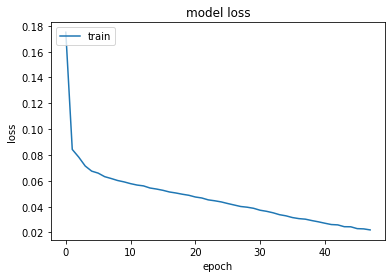

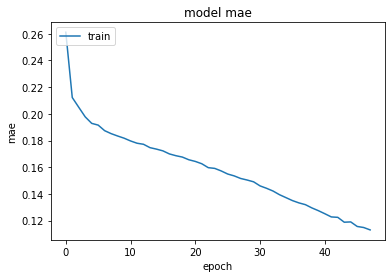

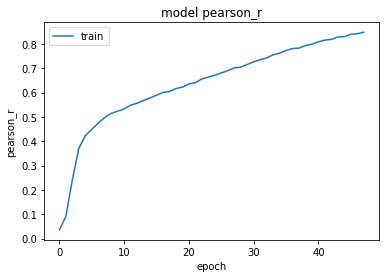

In [52]:
X = pd.DataFrame(training_set_Tokens_Filtered)
y = df_y_train

x_train = [vectorizer(word_index_train, x, mean_length_train) for x in X.to_numpy()]
x_train = np.array(x_train, dtype='int64')
y_train = y.to_numpy()


model = keras.Sequential()
model.add(embedding_layer_train)
model.add(layers.Dropout(rate=best_dropout))
model.add(layers.LSTM(units=best_units))
model.add(layers.Dense(units=best_unitsDense))
model.add(layers.Dense(3, activation="linear"))
model.compile(
    loss="mse", optimizer="nadam", metrics=["mae", pearson_r]
)
    
history = pd.DataFrame(model.fit(
    x_train,
    y_train,
    epochs=100,
    verbose=False,
    callbacks=[
        EarlyStopping(
            "loss",
            min_delta=0.001,
            patience=2,
            mode="min"
        )
    ]
).history)
# summarize history for loss
plt.plot(history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()
# summarize history for MAE
plt.plot(history['mae'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()
# summarize history for pearson
plt.plot(history['pearson_r'])
plt.title('model pearson_r')
plt.ylabel('pearson_r')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

## Use the test set to test the performance of the model

In [53]:
X_test = pd.DataFrame(test_set_Tokens_Filtered)
x_test = [vectorizer(word_index_train, x, mean_length_train) for x in X_test.to_numpy()]
x_test = np.array(x_test, dtype='int64')
y_test = df_y_test
y_test = y_test.to_numpy()
test_evaluation_LSTM = dict(zip(model.metrics_names, model.evaluate(x_test, y_test, verbose=1)))

63/63 [==============================] - 1s 11ms/step - loss: 0.0743 - mae: 0.2058 - pearson_r: 0.3309


In [54]:
test_evaluation_LSTM

{'loss': 0.07429594546556473,
 'mae': 0.2057926505804062,
 'pearson_r': 0.3308970034122467}

## Use all the data available (training, validation and test) to create the final model

In [55]:
voc_test = test_set.vocabulary

In [56]:
voc_all = list(set(voc_train + voc_test))
voc_all.append('<UNK>')
word_index_all = dict(zip(voc_all, range(len(voc_all))))

In [57]:
all_tokens = training_set_Tokens_Filtered + test_set_Tokens_Filtered

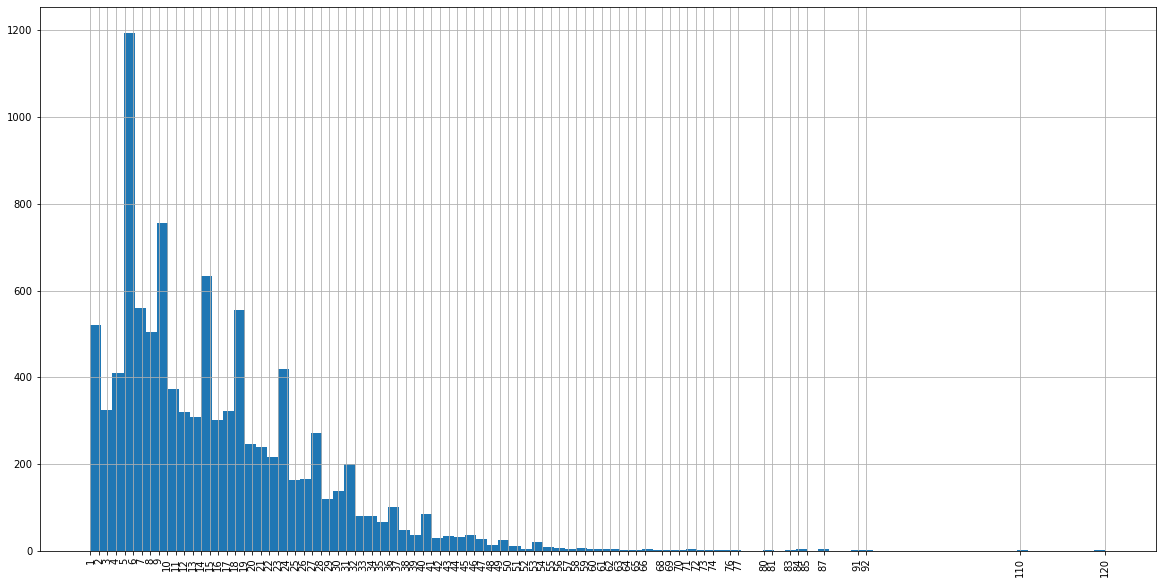

count    10052.000000
mean        15.377935
std         11.431216
min          1.000000
25%          7.000000
50%         13.000000
75%         21.000000
max        120.000000
dtype: float64


In [58]:
metrics_all, mean_length_all = plot_length_texts(all_tokens)
print(metrics_all)

In [59]:
mean_length_all

15

In [60]:
embedding_matrix_all = create_embedding_matrix(voc_all, gen, word_index_all, BRM_emot_filtered)

In [61]:
embedding_layer_all = Embedding(
    len(voc_all),
    gen.vector_size+3,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix_all),
    trainable=False,
)

In [62]:
X_all = pd.concat([X, X_test])
y_all = pd.concat([df_y_train, df_y_test])

### Create the final model with all the data available and the best parameters found

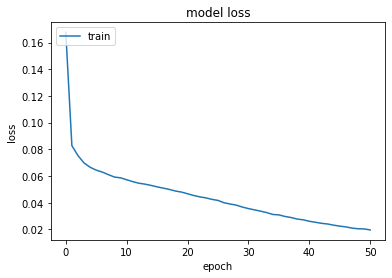

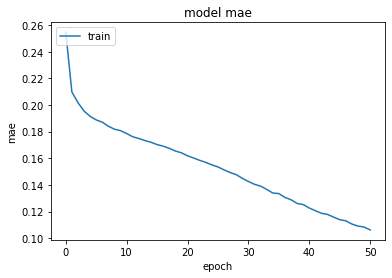

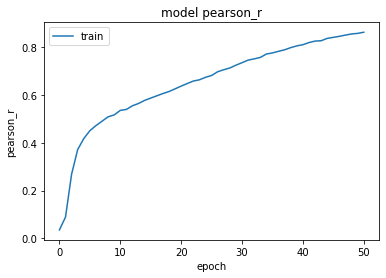

In [63]:
x_train = [vectorizer(word_index_all, x, mean_length_all) for x in X_all.to_numpy()]
x_train = np.array(x_train, dtype='int64')
y_train = y_all.to_numpy()


model_all = keras.Sequential()
model_all.add(embedding_layer_all)
model_all.add(layers.Dropout(rate=best_dropout))
model_all.add(layers.LSTM(units=best_units))
model_all.add(layers.Dense(units=best_unitsDense))
model_all.add(layers.Dense(3, activation="linear"))
model_all.compile(
    loss="mse", optimizer="nadam", metrics=["mae", pearson_r]
)

history = pd.DataFrame(model_all.fit(
    x_train,
    y_train,
    epochs=100,
    verbose=False,
    callbacks=[
        EarlyStopping(
            "loss",
            min_delta=0.001,
            patience=2,
            mode="min"
        )
    ]
).history)

# summarize history for loss
plt.plot(history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()
# summarize history for MAE
plt.plot(history['mae'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()
# summarize history for pearson
plt.plot(history['pearson_r'])
plt.title('model pearson_r')
plt.ylabel('pearson_r')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

# Get the data from the Cornell Movie-Dialogs Corpus
## Select a random title from the database

In [64]:
def get_random_title():
    """
    Function that takes a random movie title from the mongodb that contains the data of the Cornell Movie-Dialogs
    Corpus.
    
    Parameters
    ------------------------
        
    Returns
    ------------------------
    The random movie title.
    """
    db_name = 'movie-dialogs'
    collection_name = 'movies'
    m = {'$sample': { 'size': 1 } }
    p = {'$project': {'_id': 0, 'title':1}}
    pipeline = [m, p]
    db = pymongo.MongoClient()[db_name]
    collection = db[collection_name]
    cursor = collection.aggregate(pipeline)
    with cursor:
        for record in cursor:
            title_movie_random = record['title']
    return title_movie_random

In [65]:
def get_titles():
    """
    Function that collect all the movie title in the mongodb.
    
    Parameters
    ------------------------
        
    Returns
    ------------------------
    The list of movie titles contained in the mongodb.
    """
    db_name = 'movie-dialogs'
    collection_name = 'movies'
    p = {'$project': {'_id': 0, 'title':1}}
    pipeline = [p]
    db = pymongo.MongoClient()[db_name]
    collection = db[collection_name]
    cursor = collection.aggregate(pipeline)
    list_titles = []
    with cursor:
        for record in cursor:
            title_movie = record['title']
            list_titles.append(title_movie)
    return list_titles

In [66]:
get_titles()

['10 things i hate about you',
 '1492: conquest of paradise',
 '15 minutes',
 '2001: a space odyssey',
 '48 hrs.',
 'the fifth element',
 '8mm',
 'a nightmare on elm street 4: the dream master',
 'a nightmare on elm street: the dream child',
 'the atomic submarine',
 'affliction',
 'air force one',
 'airplane ii: the sequel',
 'airplane!',
 'alien nation',
 'aliens',
 'amadeus',
 'an american werewolf in london',
 'american madness',
 'american outlaws',
 'american psycho',
 'antitrust',
 'austin powers: international man of mystery',
 'the avengers',
 'bachelor party',
 'backdraft',
 'bad lieutenant',
 'bamboozled',
 'barry lyndon',
 'basic',
 'big fish',
 'birthday girl',
 'black snake moan',
 'black rain',
 'blade runner',
 'blast from the past',
 'blue velvet',
 'the boondock saints',
 'bottle rocket',
 'the bourne supremacy',
 'braveheart',
 'the butterfly effect',
 'casablanca',
 'cast away',
 'the cider house rules',
 'confidence',
 'croupier',
 'dark star',
 'dark angel',
 'det

In [67]:
title_movie_random = get_random_title()
title_movie_random

'lÃ©on'

## Get the characters list with their number of lines ordered by the number of lines

In [68]:
def get_characters_with_number_lines_ordered(title:str):
    """
    Function that takes the movie title and return the list of characters that apper in it ordere by the number of 
    utterances of each character.
    
    Parameters
    ------------------------
    title:str,
        The movie title.
        
    Returns
    ------------------------
    A list of dicts. Each dict contains the character id and its number of utterances.
    """
    db_name = 'movie-dialogs'
    collection = 'lines'
    m = {'$match': 
         {
            'character.movie.title': title
         }
        }
    g = {'$group': {'_id':"$character.id", 'totalLines': { '$sum':1 }}}
    s = {'$sort' : {'totalLines' : -1}} 
    #l = {'$limit':1}
    p = {'$project': {'_id': 1, 'totalLines': 1}}
    pipeline = [m, g, s, p]
    db = pymongo.MongoClient()[db_name]
    collection = db[collection]
    all_lines = collection.aggregate(pipeline)
    results = []
    with all_lines:
        for record in all_lines:
            dict_res = {}
            dict_res['character_id'] = record['_id']
            dict_res['n_lines'] = record['totalLines']
            results.append(dict_res)
    return results

In [69]:
get_characters_with_number_lines_ordered(title_movie_random)

[{'character_id': 'u1730', 'n_lines': 98},
 {'character_id': 'u1728', 'n_lines': 83},
 {'character_id': 'u1735', 'n_lines': 28},
 {'character_id': 'u1732', 'n_lines': 11},
 {'character_id': 'u1727', 'n_lines': 8},
 {'character_id': 'u1731', 'n_lines': 6},
 {'character_id': 'u1729', 'n_lines': 6},
 {'character_id': 'u1734', 'n_lines': 5},
 {'character_id': 'u1726', 'n_lines': 4},
 {'character_id': 'u1733', 'n_lines': 3}]

## Get all the lines of a character in a movie.

In [70]:
def get_lines(title: str, id_character: str):
    """
    Function that takes the movie title and the character id and returns a list with all the utterances for that 
    character and the name of the character.
    
    Parameters
    ------------------------
    title:str,
        The movie title.
    id_character: str,
        The id of the character.
        
    Returns
    ------------------------
    A list of utterances ordered by the line id and the name of the character.
    """
    db_name = 'movie-dialogs'
    collection = 'conversations'
    m = {'$match':
            {'$and':
            [
                {'$or':
                [{'character_a.id': id_character},
                 {'character_b.id': id_character}]
                },
                {'movie.title': title}
            ]}
        }
    s = {'$sort' : {'id' : 1}} 
    p = {'$project': {'_id': 0}}
    pipeline = [m, p]
    db = pymongo.MongoClient()[db_name]
    collection = db[collection]
    all_lines = collection.aggregate(pipeline)
    texts_id_carattere_principale = []
    with all_lines:
        for record in all_lines:
            if record['character_a']['id'] == id_character:
                name_carattere_principale = record['character_a']['name']
                id_carattere2_conversazione = record['character_b']['id']
                name_carattere2 = record['character_b']['name']
            else:
                id_carattere2_conversazione = record['character_a']['id']
                name_carattere2 = record['character_a']['name']
                name_carattere_principale = record['character_b']['name']
            list_lines = record['lines']
            for dict_line in list_lines:
                if dict_line['character'] == id_character:
                    line_id = dict_line['line']
                    line_text = dict_line['text']
                    line_talking_to_id = id_carattere2_conversazione
                    line_taking_to_name = name_carattere2
                    dict_line_new = dict()
                    dict_line_new['line_id'] = line_id
                    dict_line_new['text'] = line_text
                    dict_line_new['talking_to_id'] = line_talking_to_id
                    dict_line_new['talking_to_name'] = line_taking_to_name
                    texts_id_carattere_principale.append(dict_line_new)
    texts_id_carattere_principale_sorted = sorted(texts_id_carattere_principale, key=lambda d: d['line_id']) 
    return texts_id_carattere_principale_sorted, name_carattere_principale

## Transform the texts into lists of tokens

In [71]:
nlp = spacy.load("en_core_web_sm")

In [72]:
def preprocessing(text):
    expanded_text = contractions.fix(text)
    t = re.sub('-', ' ', expanded_text)
    t = re.sub(r'[^a-zA-Z ]+', ' ', t)
    return t

In [73]:
def check(token):
    if token in string.punctuation:
        return False
    elif token.startswith("'"):
        return False
    elif token == '--':
        return False
    elif token == '``':
        return False
    else:
        return True

In [74]:
def tokenize(text):
    try:
        tokens = [x.lemma_ for x in nlp(text.lower())]
        return tokens
    except TypeError:
        return []

# Get outputs
- emotional profile of a character
- time line of VAD values
- how other characters affect VAD values of a character

In [75]:
def get_tokens_from_texts(list_text:list):
    """
    Function that takes a list of texts and conver each text into a list of tokens.
    
    Parameters
    ------------------------
    list_text:list,
        The list containing the texts.
        
    Returns
    ------------------------
    A pd.DataFrame with the tokenization of all the texts.
    """
    character_text_Tokens = []
    for text in list_text:
        text = preprocessing(text)
        character_text_Tokens.append(tokenize(text))
    return pd.DataFrame(character_text_Tokens)

In [76]:
def get_predictions(X: pd.DataFrame, word_index: dict, length:int, model: keras.Model):
    """
    Function that predict the VAD values for each text (list of tokens).
    
    Parameters
    ------------------------
    X:pd.DataFrame,
        The texts represented as list of tokens
    word_index: dict,
        Dictionary that contains the int value that represent each word in the vocabulary.
    length:int,
        The length of the text.
    model: keras.Model,
        The model to be used for the predictions.
        
        
    Returns
    ------------------------
    A nd.array with the predictions.
    """
    x_test = [vectorizer(word_index, x, length) for x in X.to_numpy()]
    x_test = np.array(x_test, dtype='int64')
    predictions = model.predict(x_test)
    predictions_list = predictions.tolist()
    return np.array(predictions_list)

In [77]:
def get_minMax_value_from_lists(list_of_list: list):
    """
    Function that calculates the minimum e maximum values contained in a list of list.
    
    Parameters
    ------------------------
    list_of_list: list,
        The list of list to be examined.        
        
    Returns
    ------------------------
    The minimum and the maximum values.
    """
    min_val = None
    max_val = None
    for x in list_of_list:
        if min_val is not None:
            if min(x) < min_val:
                min_val = min(x)
        else:
            min_val = min(x)
        if max_val is not None:
            if max(x) > max_val:
                max_val = max(x)
        else:
            max_val = max(x)
    return min_val, max_val

In [78]:
def camelCase_noSpace(string:str):
    """
    Function that convert a string in camel case and remove the spaces.
    
    Parameters
    ------------------------
    stringa:str,
        The string to be examined.        
        
    Returns
    ------------------------
    The string with camel case and no spaces.
    """
    if ' ' in string:
        string = string.title().replace(" ", "")
    return string

In [79]:
camelCase_noSpace("american madness")

'AmericanMadness'

In [80]:
def plot_boxplot(pred_V:list, pred_A:list, pred_D:list, name_character: str, title: str, save:bool=False):
    """
    Function that create a box plot for each VAD dimensions in a single plot.
    
    Parameters
    ------------------------
    pred_V:list,
        List that contains the V values predicted.  
    pred_A:list,
        List that contains the A values predicted.
    pred_D:list,
        List that contains the D values predicted.
    name_character: str,
        The name of the character.
    title: str,
        The movie title.
    save:bool=False,
        Whether to save the plot.
        
    Returns
    ------------------------
    
    """
    data = [pred_V, pred_A, pred_D]
    fig = plt.figure(figsize =(10, 7))
    ax = fig.add_subplot(111)

    # Creating axes instance
    bp = ax.boxplot(data, patch_artist = True,
                    vert = 1)
    colors = ['blue', 'orange',
              'green']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    ax.set_xticklabels(['Valence', 'Arousal',
                        'Dominance'])

    plt.title("Emotional profile of character {0} in movie {1}".format(name_character,title_movie_random.upper()))
    ax.set_ylim(1, 5)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    title = camelCase_noSpace(title)
    if save:
        plt.savefig(os.path.join('boxplot_{0}-{1}.eps'.format(title, name_character)), dpi=300, format='eps', bbox_inches='tight')
    plt.show()

In [81]:
def plot_matrix(pred_V:list, pred_A:list, pred_D:list, unique_second_char:list, lines_character:list, 
                name_character:str, title:str, save:bool=False):
    """
    Function that create a heatmap with the difference between the mean VAD values of the character and the mean VAD
    values of the character when she/he is speaking to a particular character.
    
    Parameters
    ------------------------
    pred_V:list,
        List that contains the V values predicted.  
    pred_A:list,
        List that contains the A values predicted.
    pred_D:list,
        List that contains the D values predicted.
    unique_second_char:list,
        List of the characters with which the character speaks to.
    lines_character:list,
        List of the lines of the characters.
    name_character: str,
        The name of the character.
    title: str,
        The movie title.
    save:bool=False,
        Whether to save the plot.
        
    Returns
    ------------------------
    
    """
    pred_V_mean = mean(pred_V)
    pred_A_mean = mean(pred_A)
    pred_D_mean = mean(pred_D)
    Matrix_differences = np.empty([3, len(unique_second_char)])
    for i, char in enumerate(unique_second_char):
        Valence = [dict_res['V'] for dict_res in lines_character if dict_res['talking_to_name'] == char]
        Valence = mean(Valence)
        Matrix_differences[0][i] = Valence - pred_V_mean
        Arousal = [dict_res['A'] for dict_res in lines_character if dict_res['talking_to_name'] == char]
        Arousal = mean(Arousal)
        Matrix_differences[1][i] = Arousal - pred_A_mean
        Dominance = [dict_res['D'] for dict_res in lines_character if dict_res['talking_to_name'] == char]
        Dominance = mean(Dominance)
        Matrix_differences[2][i] = Dominance - pred_D_mean
        
    %matplotlib inline
    cm = sns.color_palette("vlag", as_cmap=True)
    x=pd.DataFrame(Matrix_differences, columns=unique_second_char, index=['Valence', 'Arousal', 'Dominance'])
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(x, annot=True, cmap=cm, square=True, fmt=".2f", ax = ax, center=0.0)
    ax.set_title('Character: {0}, Movie: {1}'.format(name_character, title.upper()))
    title = camelCase_noSpace(title)
    if save:
        fig.savefig(os.path.join('matrix_{0}-{1}.eps'.format(title, name_character)), dpi=300, format='eps', bbox_inches='tight')

In [82]:
def plot_lines_in_time(line_id:list, talking_to_name:list, pred_V:list, pred_A: list, pred_D: list, 
                       name_character: str, title:str, save:bool=False):
    """
    Function that create a lineplot with the VAD values during time.
    
    Parameters
    ------------------------
    line_id:list, 
        List of the lines id.
    talking_to_name:list, 
        List of the names to which the character is talking to.
    pred_V:list,
        List that contains the V values predicted.  
    pred_A:list,
        List that contains the A values predicted.
    pred_D:list,
        List that contains the D values predicted.
    name_character: str,
        The name of the character.
    title: str,
        The movie title.
    save:bool=False,
        Whether to save the plot.
        
    Returns
    ------------------------
    
    """
    list_of_list = []
    for i, line_number in enumerate(line_id):
        list_ = []
        list_.append(line_number + '-' +talking_to_name[i])
        list_.append(pred_V[i])
        list_.append(pred_A[i])
        list_.append(pred_D[i])
        list_of_list.append(list_)
    
    #get min value for the plot
    min_y_val, max_y_val = get_minMax_value_from_lists([pred_V, pred_A, pred_D])
    
    # create plot
    for i in range(0, len(list_of_list), 20):
        df = pd.DataFrame(list_of_list[i:i+20],
                          columns=['Line', 'Valence', 'Arousal', 'Dominance'])

        # plot grouped bar chart
        df.plot(x='Line',
                kind='line',
                stacked=False,
                title='VAD of character {0} in time'.format(name_character),
                figsize=(20,2),
                ylim=(min_y_val-0.1, max_y_val+0.1),
                grid=True,
                rot=90,
                )
        plt.xticks(ticks=df.index, labels=df['Line'].values.tolist(), rotation = 'vertical')
        title = camelCase_noSpace(title)
        if save:
            plt.savefig(os.path.join('timeLine_{0}_{1}-{2}.eps'.format(i,title, name_character)), dpi=300, format='eps', bbox_inches='tight')
        plt.show()

In [83]:
def get_output(title:str, character_id:str):
    """
    Function that create the plots for the character in the movie.
    
    Parameters
    ------------------------
    title:str,
        The movie title.
    character_id:str,
        The id of the character.
        
    Returns
    ------------------------
    
    """
    #get the lines of the character
    lines_character, name_character = get_lines(title, character_id)
    texts = [dict_res['text'] for dict_res in lines_character]
    line_id = [dict_res['line_id'] for dict_res in lines_character]
    talking_to_name = [dict_res['talking_to_name'] for dict_res in lines_character]
    unique_second_char = list(set(talking_to_name))
    
    #convert the lines into tokens list
    test_set = get_tokens_from_texts(texts)
    
    #get the prediction from the model
    predictions = get_predictions(test_set, word_index_all, mean_length_all, model_all)
    
    #update the dictionary of the lines with the predictions
    for i, dict_i in enumerate(lines_character):
        dict_i['V'] = predictions[i][0]
        dict_i['A'] = predictions[i][1]
        dict_i['D'] = predictions[i][2]
    
    pred_V = [dict_res['V'] for dict_res in lines_character]
    pred_A = [dict_res['A'] for dict_res in lines_character]
    pred_D = [dict_res['D'] for dict_res in lines_character]      
    
    # BOXPLOT
    plot_boxplot(pred_V, pred_A, pred_D, name_character, title) 
    
    
    # plot the values as line in time
    plot_lines_in_time(line_id, talking_to_name, pred_V, pred_A, pred_D, name_character, title)
 
    
    # MATRIX DIFFERENCES FROM MEAN
    plot_matrix(pred_V, pred_A, pred_D, unique_second_char, lines_character, name_character, title)

In [84]:
def get_output_n_characters(title:str, n_characters:int):
    """
    Function that create the plots for n characters (ordered by the number of utterances they have)
    in the movie.
    
    Parameters
    ------------------------
    title:str,
        The movie title.
    n_characters:int,
        The number of characters for which we want the plots.
        
    Returns
    ------------------------
    
    """
    list_char_nLines = get_characters_with_number_lines_ordered(title)
    if n_characters > len(list_char_nLines):
        print('There are only {0} characters'.format(len(list_char_nLines)))
        n_characters = len(list_char_nLines)
    
    for i in range(n_characters):
        character_id = list_char_nLines[i]['character_id']
        get_output(title, character_id)

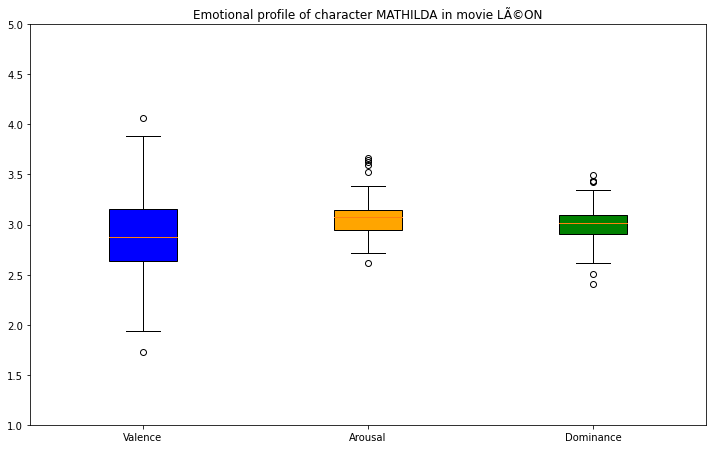

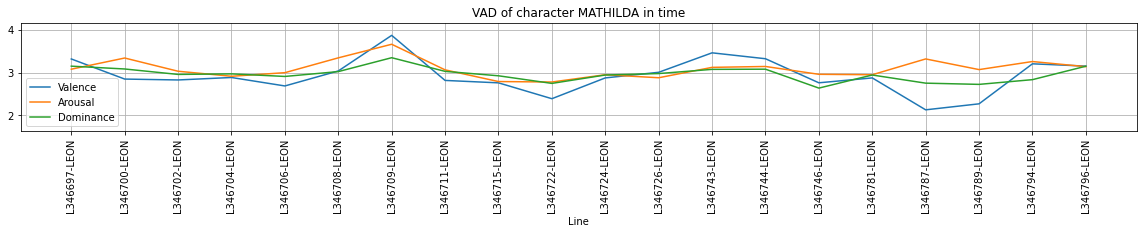

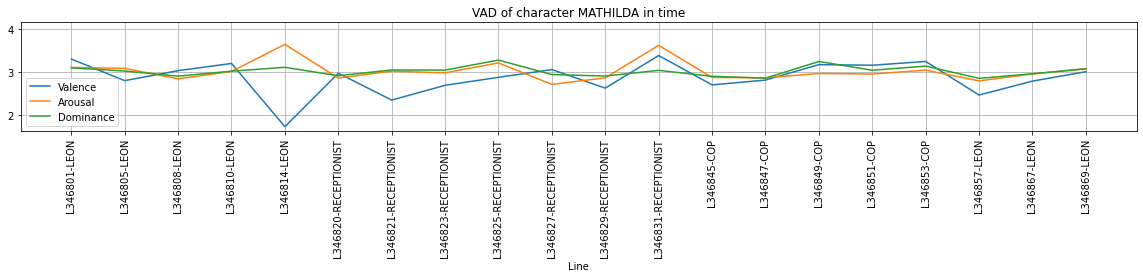

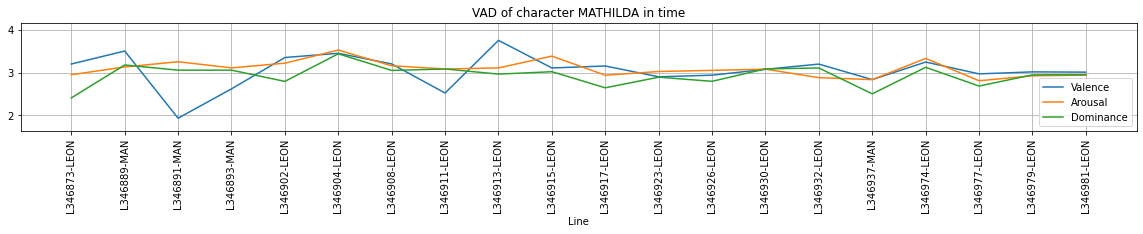

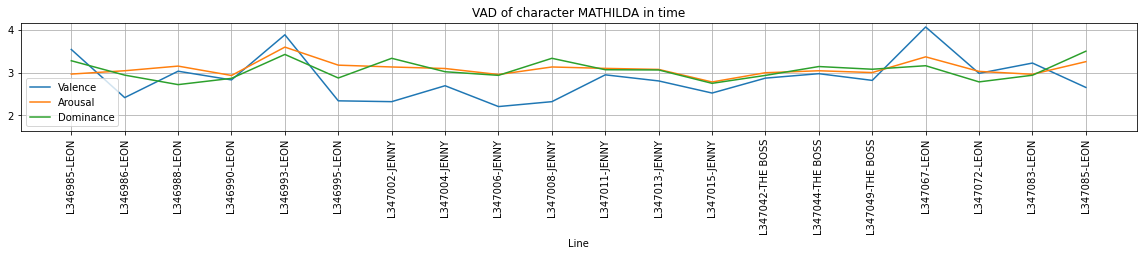

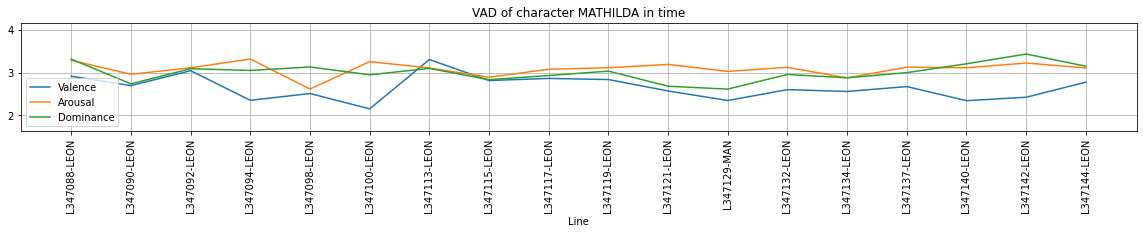

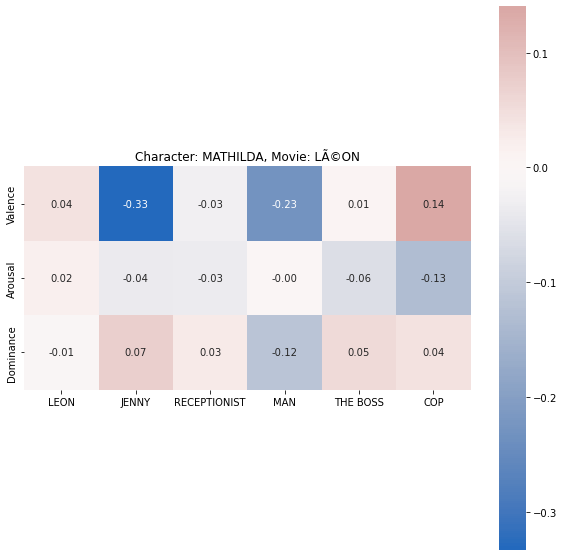

In [85]:
get_output_n_characters(title_movie_random, 1)